# Adapting the topography (work in progress)

* The topography/bathymetry is extract from a NetCDF file
* Adapted topographies:
   * GEBCO
   * EMODNET Bathymetry
* Other topographies can be used as long as they define the NetCDF variables `lon`, `lat` and `bat` (positive above sea-level and negative below, in DIVAnd the convention is however, in sea water z is positive).

* This notebook illustrates how to land-sea mask can be changed (to exclude for example a lake).

In [1]:
using PyPlot
using divand

In [2]:
dx = dy = 0.125
lonr = 2.5:dx:12.
latr = 42.3:dy:44.6

# https://b2drop.eudat.eu/s/x83MSV8yUF934bL/download  gebco_30sec_8.nc
# https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download  gebco_30sec_4.nc
# https://b2drop.eudat.eu/s/o0vinoQutAC7eb0/download  gebco_30sec_16.nc

bathname = "gebco_30sec_4.nc"

if !isfile(bathname)
    download("https://b2drop.eudat.eu/s/ACcxUEZZi6a4ziR/download",bathname)
else
    info("Bathymetry file already downloaded")
end

bathisglobal = true

INFO: Bathymetry file already downloaded


true

`divand.extract_bath` loads the bathymetry at the resolution defined in the NetCDF file while `divand.load_bath` reduces the resolution to match the resolution of the analysis.

In [3]:
?extract_bath

search: extract_bath



```
bx,by,b = divand.extract_bath(bath_name,isglobal,xi,yi)
```

Extract the bathymetry from the NetCDF file `bathname`. The parameter `isglobal`  is true if the NetCDF file covers the whole globe and thus the last longitude  point can be considered to be right next to the first longitude point. `xi` and `yi` are vectors defining the bounding box of the data. No  interpolation is performed.

b is positive in the water and negative in the air.


size(b) = (293, 76)

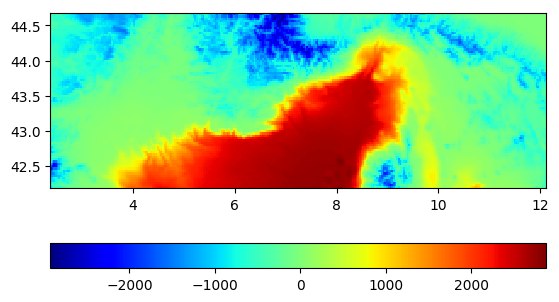

(293, 76)

In [4]:
bx,by,b = extract_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

@show size(b)

In [5]:
?load_bath

search: load_bath



```
xi,yi,bath = divand.load_bath(bath_name,isglobal,xi,yi)
```

Load the bathymetry from the NetCDF file `bathname`. The parameter `isglobal` is true if the NetCDF file covers the whole globe and  thus the last longitude point can be considered to be right next to the first longitude point. `xi` and `yi` is a vector of the longitude and latitude grid onto which the bathymetry should be  interpolated.


size(b) = (77, 19)

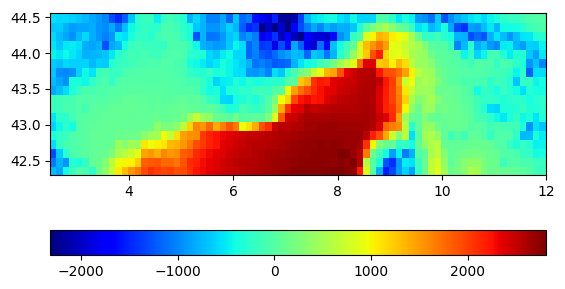

(77, 19)

In [6]:
bx,by,b = load_bath(bathname,true,lonr,latr)

pcolor(bx,by,b'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180))

@show size(b)

In [7]:
depthr = [0,10,20]
mask = falses(size(b,1),size(b,2),length(depthr))

for k = 1:length(depthr)
    for j = 1:size(b,2)
        for i = 1:size(b,1)
            mask[i,j,k] = b[i,j] >= depthr[k]
        end
    end
end

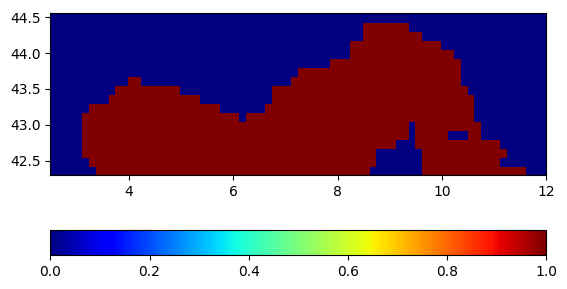

In [8]:
pcolor(bx,by,Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(mean([ylim()...]) * pi/180)) # fixes the aspect ratio

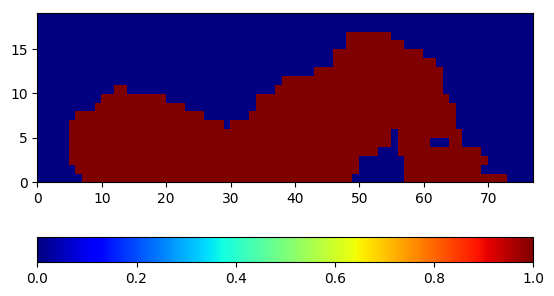

In [9]:
pcolor(Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(43.5 * pi/180))


Example: Put an island

In [10]:
mask[63,8,:] = false

false

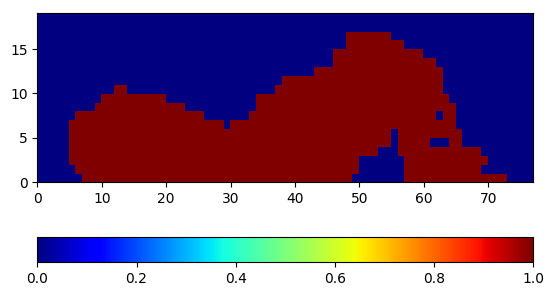

In [11]:
pcolor(Float64.(mask[:,:,1])'); colorbar(orientation="horizontal")
gca()[:set_aspect](1/cos(43.5 * pi/180))
